In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_datareader
import datetime as dt
import pandas_datareader.data as web
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
from scipy.stats import norm
import statsmodels.api as sm

In [16]:
data = pd.read_csv("Nifty 50 Historical Data.csv")
data.columns = ["Month","Data"]
data.set_index("Month",inplace = True)
data= data[169:]
data

,Data
Month,
01-01-2010,4882.05
02-01-2010,4922.30
03-01-2010,5249.10
04-01-2010,5278.00
05-01-2010,5086.30
...,...
08-01-2022,17759.30
09-01-2022,17094.35
10-01-2022,18012.20


In [17]:
data.index = pd.to_datetime(data.index)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
result = seasonal_decompose(data['Data'],model = 'additive',period = 12)

# ERROR TREND SEASONALITY(ETS) DECOMPOSITION

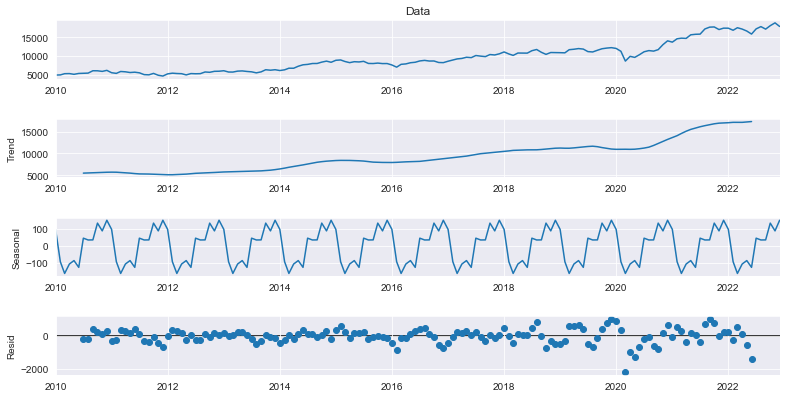

In [20]:
fig  = result.plot()
fig.set_size_inches(12,6)

Stationarity implies that mean should be constant and variance should not depend on time and covariance (speed of change in variance) should not be a function of time.

Dicky fuller test's null hypothesis is that data is non stationery,alternate it has no unit root and it is stationery, small p value shows strong evidence against the null hypothesis
https://people.duke.edu/~rnau/arimrule.htm

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
ADF = adfuller(data["Data"])

In [23]:
def ADF_CHECK(time_series):
    
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test statistic (T value to be compared with z values)","p-value","# of lags","Num of observations used"]
    
    for value,label in zip(result,labels):
        print(label + ":" + str(value))
    
    if result[1]<=0.05:
        print("Strong evidence against null hypothesis")
        print("Reject null hypothesis")
        print("Data does not have a unit root and is stationery")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and it is non-stationery")

In [24]:
ADF_CHECK(data["Data"])

Augmented Dicky-Fuller Test
ADF Test statistic (T value to be compared with z values):1.177397677284519
p-value:0.9958259411954967
# of lags:12
Num of observations used:143
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and it is non-stationery


<AxesSubplot:xlabel='Month'>

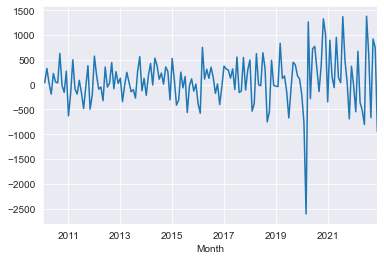

In [25]:
data["First Difference"] = data["Data"]-data["Data"].shift(1)
data["First Difference"].plot()

In [26]:
ADF_CHECK(data["First Difference"].dropna())

Augmented Dicky-Fuller Test
ADF Test statistic (T value to be compared with z values):-3.966816041652662
p-value:0.0015945952093983588
# of lags:11
Num of observations used:143
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationery


<AxesSubplot:xlabel='Month'>

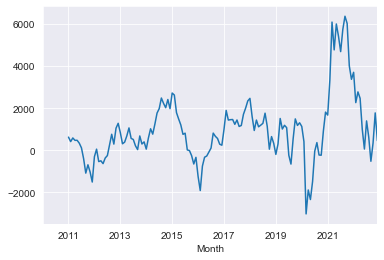

In [27]:
data["Seasonal Difference"] = data["Data"]-data["Data"].shift(12)
data["Seasonal Difference"].plot()

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

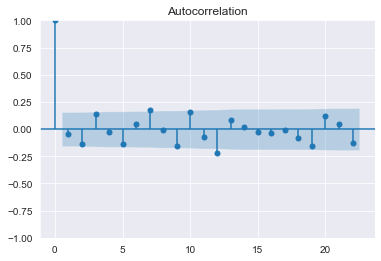

In [29]:
ACF = plot_acf(data["First Difference"].dropna())

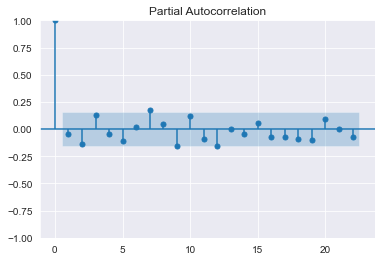

In [30]:
PACF = plot_pacf(data["First Difference"].dropna())

In [31]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
model = sm.tsa.statespace.SARIMAX(data["Data"],order = (1,1,1),seasonal_order = (1,1,1,12))

Order = (P,D,Q) where p is lags in AR, d is differencing and q is lags in MA

Seasonal Order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/#:~:text=In%20the%20SARIMAX%20models%20parameter%2C%20we%20need%20to,Mathematically%20we%20can%20represent%20the%20model%20like%20this.

In [33]:
results = model.fit()

In [34]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Data   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1098.221
Date:                            Sun, 18 Jun 2023   AIC                           2206.443
Time:                                    19:39:42   BIC                           2221.257
Sample:                                01-01-2010   HQIC                          2212.463
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9903      0.292     -3.392      0.001      -1.563      -0.418
ma.L1          0.9989      1.222   

<AxesSubplot:xlabel='Month'>

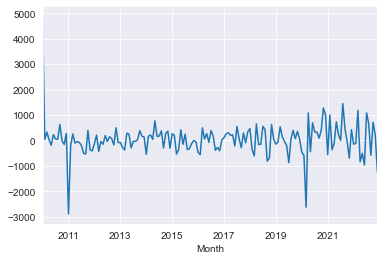

In [35]:
results.resid.plot()

<AxesSubplot:xlabel='Month'>

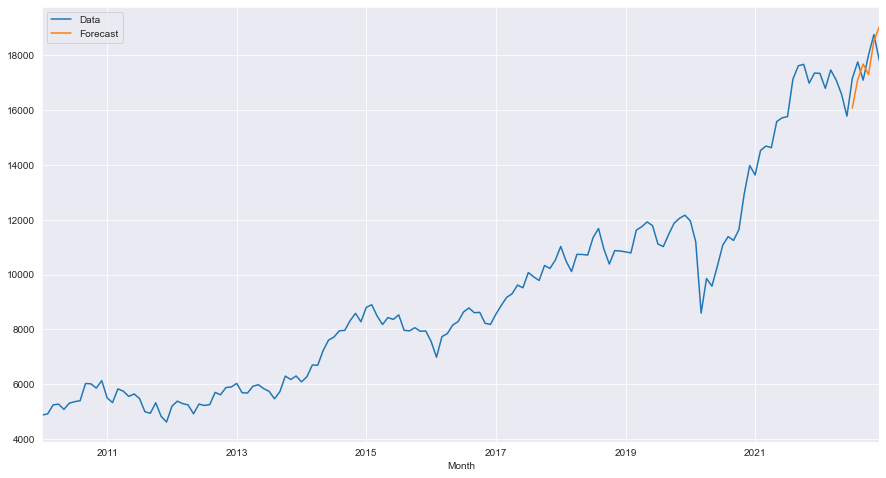

In [36]:
data["Forecast"] = results.predict(start =150, end = 156)
data[["Data","Forecast"]].plot(figsize = (15,8))
#Orange one is the one predicted by the arima model

In [37]:
data.tail()

,Data,First Difference,Seasonal Difference,Forecast
Month,,,,
2022-08-01,17759.30,601.05,627.10,17111.192518
2022-09-01,17094.35,-664.95,-523.80,17679.717209
2022-10-01,18012.20,917.85,340.55,17300.363574
2022-11-01,18758.35,746.15,1775.15,18531.545080
2022-12-01,17806.80,-951.55,452.75,19044.241017


In [38]:
from pandas.tseries.offsets import DateOffset

In [39]:
future_dates = [data.index[-1] + DateOffset(months = x) for x in range(1,24)]

In [40]:
future_data = pd.DataFrame(index = future_dates,columns = data.columns)

In [41]:
final_data = pd.concat([data,future_data])
final_data.head()

,Data,First Difference,Seasonal Difference,Forecast
2010-01-01,4882.05,NaN,NaN,NaN
2010-02-01,4922.3,40.25,NaN,NaN
2010-03-01,5249.1,326.8,NaN,NaN
2010-04-01,5278.0,28.9,NaN,NaN
2010-05-01,5086.3,-191.7,NaN,NaN


In [42]:
final_data["Forecast"] = results.predict(start = 156,end = 180)
final_data["Forecast"][156]

17775.64703444288

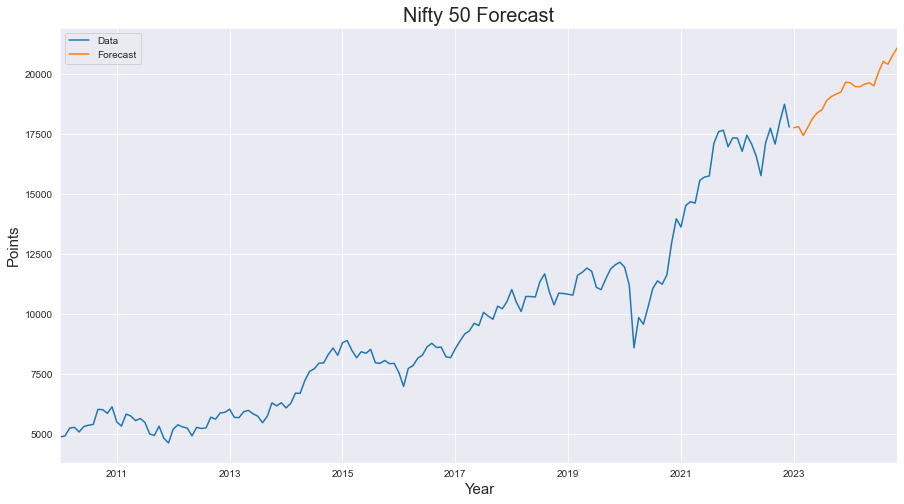

In [43]:
final_data["Data"].plot()
final_data["Forecast"].plot(figsize = (15,8))
plt.title("Nifty 50 Forecast",size = 20)
plt.xlabel("Year",size = 15)
plt.ylabel("Points",size = 15)
plt.legend();